# **Predicting New York City Taxi Fair using a Full ANN with PyTorch**

**Context and objective:**  
In this use case, we are tasked with predicting the fare amount for a taxi ride in New York City given the pickup and dropoff locations. This is originally a Kaggle competition we can find on this [link](https://www.kaggle.com/competitions/new-york-city-taxi-fare-prediction/overview). In the description, it is mentionned that we can get a basic estimate based on just the distance between the two points that will result in an RMSE of $5-$8 depending on the model used. The challenge is to do better than this using Machine Learning techniques. In this work, I used a full artificial neural network with the PyTorch framework that I tested on subset of the original dataset, this resulted in an RSME of 3.79.

**Dataset:**  

The dataset contains 6 features and 1 target.
- pickup_datetime: time when the taxi ride started.
- pickup_longitude: longitude coordinate of the pickup ride.
- pickup_latitude: latitude coordinate of the pickup ride.
- dropoff_longitude: longitude coordinate of the dropoff ride.
- dropoff_latitude: latitude coordinate of the dropoff ride.
- passenget_count: the number of passengers.
- fare_amount: this is the target variable indicating the dollar amount of the taxi ride.

Because of computational limitations I have on my computer, I used a subset of 120000 observations from the original dataset that contains 55 million observations.

**Note:** this code was written on Google Colab.  
**Programming language:** Python.  
**Packages:** numpy, pandas, time, pytorch, matplotlib.  

**Import libraries**

In [2]:
# import the relevant libraries
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

**Read and explore the data**

In [5]:
# read the dataset
df = pd.read_csv('C:/Users/sofia/Documents/IT/Datasets/TaxiFaires.csv', delimiter = ';')
df.head() # print the first five rows

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [ ]:
# read the dataset
df = pd.read_csv(io.BytesIO(uploaded['TaxiFares.csv']), delimiter = ';')
df.head() # print the first five rows

In [6]:
# print shape of the dataset
df.shape

(188384, 8)

In [7]:
# check for missing values
df.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    2
dropoff_latitude     2
passenger_count      0
dtype: int64

In [8]:
# the dataframe contains 2 missing values in the "dropoff_longitude" column and 2 other missing values in the "dropoff_latitude" column
# let's deal with these missing values
df[df['dropoff_longitude'].isnull() & df['dropoff_latitude'].isnull()]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
29626,2012-12-11 12:57:00.00000013,12.5,2012-12-11 12:57:00 UTC,-73.992760,40.743098,NaN,NaN,0
51129,2013-03-21 18:07:07.0000001,86.5,2013-03-21 18:07:07 UTC,-73.991572,40.740591,NaN,NaN,0


In [9]:
# we can confirm that only two rows contain the missing values
# let's drop them
df2 = df[df['dropoff_longitude'].notnull() & df['dropoff_latitude'].notnull()]

# check for missing values
df2.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [10]:
# descriptive statistics
df2.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,188382.000000,188382.000000,188382.000000,188382.000000,188382.000000,188382.000000
mean,10.528496,-73.975044,40.747769,-73.913800,40.718420,1.731392
std,8.266386,0.748796,1.143256,3.532799,1.810428,1.359297
min,-3.000000,-74.438233,-74.006893,-740.000000,-74.006377,0.000000
25%,6.000000,-73.991312,40.738011,-73.991811,40.735678,1.000000
50%,8.100000,-73.983507,40.752162,-73.981492,40.753226,1.000000
75%,12.000000,-73.976202,40.764632,-73.968329,40.767383,2.000000
max,250.250000,40.766125,401.083332,40.802437,404.716667,6.000000


In [11]:
# the descriptive statistics show that there is a problem with the fare amount in which the minimum value is -3 dollars
# in addition there is a minimum number of passengers equals to 0
# let's check the data again to see how many rows we have with these values
# df2[(df2['fare_amount'] == -3.0) | (df2['passenger_count'] == 0)]
df2[df2['fare_amount'] == -3.0]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
60579,2015-03-28 01:42:18.0000008,-3.0,2015-03-28 01:42:18 UTC,-74.004997,40.730244,-74.006699,40.730198,1
137166,2013-08-29 11:51:10.0000004,-3.0,2013-08-29 11:51:10 UTC,-73.984460,40.759835,-73.985620,40.757950,1


In [12]:
df2[df2['passenger_count'] == 0]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
307,2015-06-02 23:16:15.00000012,34.0,2015-06-02 23:16:15 UTC,-73.974899,40.751095,-73.908546,40.881878,0
552,2012-01-28 21:33:18.0000002,4.9,2012-01-28 21:33:18 UTC,-73.955322,40.782840,-73.955797,40.773673,0
662,2012-02-27 07:24:20.0000003,6.5,2012-02-27 07:24:20 UTC,-73.983397,40.738183,-73.971395,40.758023,0
1135,2011-05-25 23:58:48.0000001,13.3,2011-05-25 23:58:48 UTC,-73.998360,40.740348,-73.946455,40.777348,0
1894,2011-10-23 11:09:28.0000001,10.1,2011-10-23 11:09:28 UTC,-73.971400,40.795000,-73.967900,40.768600,0
...,...,...,...,...,...,...,...,...
187344,2011-06-11 20:21:57.0000002,7.3,2011-06-11 20:21:57 UTC,-73.991400,40.770200,-73.989000,40.758200,0
187609,2012-02-06 23:45:01.0000003,5.7,2012-02-06 23:45:01 UTC,-73.982263,40.731633,-73.970632,40.751625,0
187715,2011-08-31 14:53:00.00000030,5.7,2011-08-31 14:53:00 UTC,-73.978100,40.752600,-73.989000,40.758400,0
187828,2011-10-07 11:55:18.0000001,4.9,2011-10-07 11:55:18 UTC,-73.995200,40.744600,-74.004700,40.731900,0


In [13]:
# we have a total of 952 rows containing these values
# we can remove all the rows lower than 0 for both columns
df3 = df2[(df2['fare_amount'] >= 1.0) & (df2['passenger_count'] >= 1)]

# check the descriptive statistics
df3.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,187420.000000,187420.000000,187420.000000,187420.000000,187420.000000,187420.000000
mean,10.539839,-73.975021,40.747747,-73.914662,40.718898,1.740204
std,8.276334,0.750711,1.146184,3.529483,1.807740,1.357155
min,2.500000,-74.438233,-74.006893,-740.000000,-74.006377,1.000000
25%,6.000000,-73.991312,40.738007,-73.991807,40.735677,1.000000
50%,8.100000,-73.983518,40.752160,-73.981490,40.753232,1.000000
75%,12.000000,-73.976205,40.764628,-73.968332,40.767385,2.000000
max,250.250000,40.766125,401.083332,40.802437,404.716667,6.000000


In [14]:
# next, it seems that the maximum pickup latitude abd longitude is greater than 400 degrees
# on the other hand, the minimum value of the dropoff longitude is -740.0
# these are not correct values since we know that latitude values range from -90 to 90 degrees and longitude values range from -180 to 180 degrees
# let's only keep the values in this range
df4 = df3[(df3['pickup_longitude'] <= 180) & (df3['pickup_longitude'] >= -180) &
          (df3['dropoff_longitude'] <= 180) & (df3['dropoff_longitude'] >= -180) &
          (df3['pickup_latitude'] <= 90) & (df3['pickup_latitude'] >= -90) &
          (df3['dropoff_latitude'] <= 90) & (df3['dropoff_latitude'] >= -90)]

# check the descriptive statistics
df4.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,187414.000000,187414.000000,187414.000000,187414.000000,187414.000000,187414.000000
mean,10.539823,-73.975021,40.745824,-73.904057,40.715015,1.740206
std,8.276288,0.750723,0.788014,2.330729,1.362004,1.357150
min,2.500000,-74.438233,-74.006893,-74.429332,-74.006377,1.000000
25%,6.000000,-73.991312,40.738007,-73.991807,40.735675,1.000000
50%,8.100000,-73.983518,40.752160,-73.981490,40.753232,1.000000
75%,12.000000,-73.976205,40.764628,-73.968332,40.767384,2.000000
max,250.250000,40.766125,41.650000,40.802437,44.600000,6.000000


In [15]:
# check the features
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187414 entries, 0 to 188383
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                187414 non-null  object 
 1   fare_amount        187414 non-null  float64
 2   pickup_datetime    187414 non-null  object 
 3   pickup_longitude   187414 non-null  float64
 4   pickup_latitude    187414 non-null  float64
 5   dropoff_longitude  187414 non-null  float64
 6   dropoff_latitude   187414 non-null  float64
 7   passenger_count    187414 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 12.9+ MB


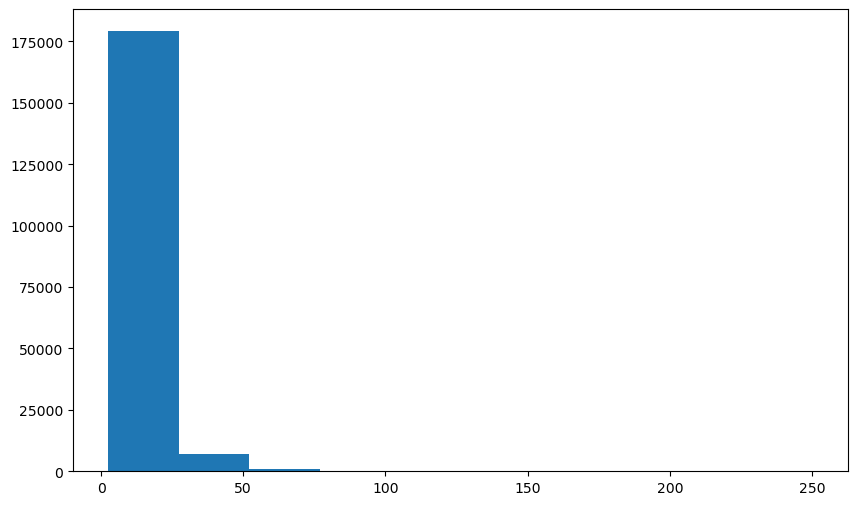

In [16]:
# the maximum fare amount is 250.25 dollars which is a little too distanced from the minimum and mean of the variable
# let's explore this variable and print its distribution plot
plt.figure(figsize = (10,6))
plt.hist(df4['fare_amount'])
plt.show()

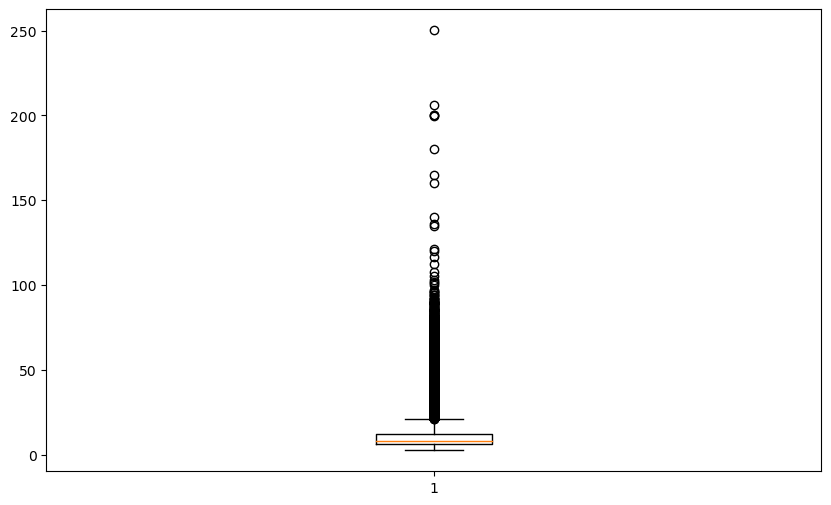

In [17]:
# print its boxplot
plt.figure(figsize = (10,6))
plt.boxplot(df4['fare_amount'])
plt.show()

In [18]:
# the distribution plots how that most of the values are below 100
# in fact if we refer to the descriptive statistics we can see that 75% of the values fall behind $12
# after making these observations, I decided to keep only values below $50
df5 = df4[df4['fare_amount'] <= 50.0]
df5.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,185946.000000,185946.000000,185946.000000,185946.000000,185946.000000,185946.000000
mean,10.144142,-73.975860,40.746525,-73.908893,40.718201,1.739354
std,6.884121,0.705128,0.745003,2.254149,1.304148,1.356467
min,2.500000,-74.133710,-74.006893,-74.267497,-73.994392,1.000000
25%,6.000000,-73.991321,40.738057,-73.991797,40.736158,1.000000
50%,8.100000,-73.983537,40.752173,-73.981529,40.753404,1.000000
75%,11.700000,-73.976267,40.764662,-73.968572,40.767492,2.000000
max,50.000000,40.766125,41.650000,40.802437,44.600000,6.000000


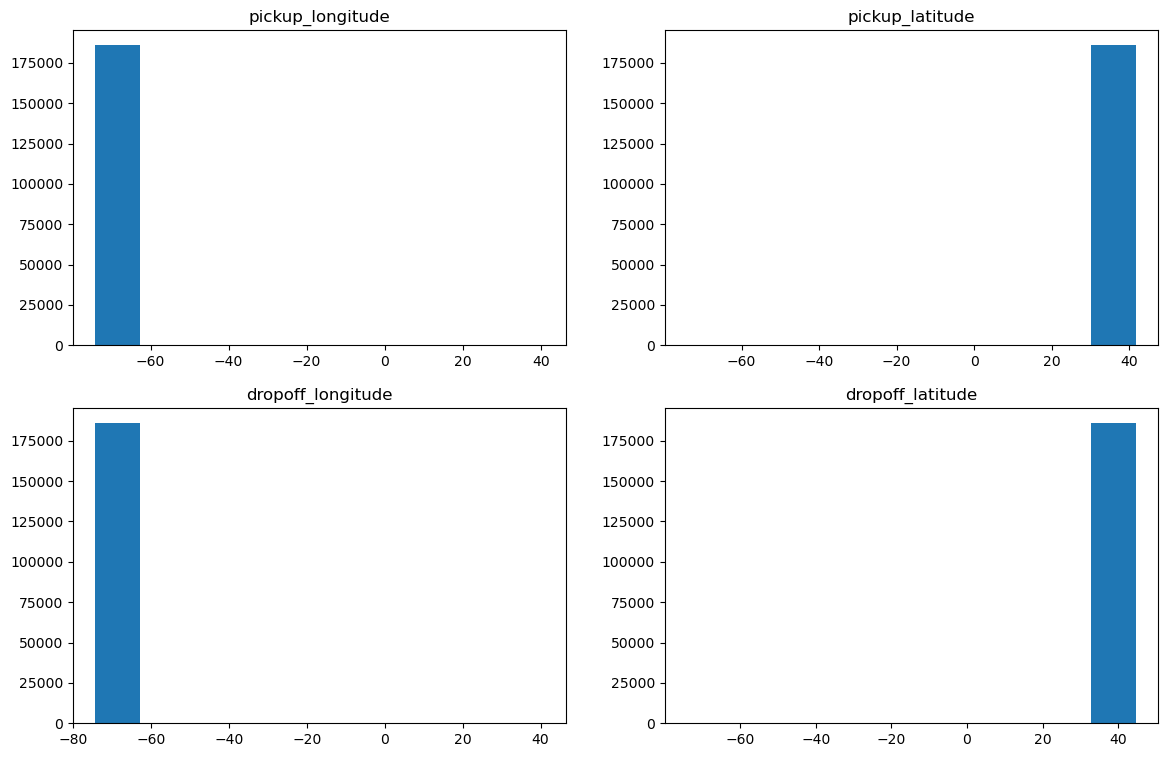

In [19]:
# what we can also observe is the maximum values of the longitudes which are greater than 40 degrees while the 75th percentile is around -73 degrees
# on the other hand, the minimum latitudes are around 40 and the 25th percentile is around -74 degrees
# let's check the distribution plots of these variables
plt.figure(figsize = (14,9))
cols = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
i = 1
for c in cols:
  plt.subplot(2,2,i)
  plt.hist(df5[c])
  plt.title(c)
  i += 1
plt.show()

In [20]:
# the distribution plots ou observations
# as a result, to remove outliers I filtered the dataset by dropping the values that fall above the 99th percentile and below the 1st percentile
thr_pickup_long = df5['pickup_longitude'].quantile(0.99)
thr_dropoff_long = df5['dropoff_longitude'].quantile(0.99)
thr_pickup_lat = df5['pickup_latitude'].quantile(0.01)
thr_dropoff_lat = df5['dropoff_latitude'].quantile(0.01)

df6 = df5[(df5['pickup_longitude'] < thr_pickup_long) &
          (df5['dropoff_longitude'] < thr_dropoff_long) &
          (df5['pickup_latitude'] > thr_pickup_lat) &
          (df5['dropoff_latitude'] > thr_dropoff_lat)]

# print the descriptive statistcs of the filtered dataframe
df6.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,180579.000000,180579.000000,180579.000000,180579.000000,180579.000000,180579.000000
mean,9.656484,-73.982936,40.752030,-73.978274,40.752871,1.740191
std,5.820693,0.014117,0.020337,0.023288,0.027632,1.357836
min,2.500000,-74.042958,40.686561,-74.267497,40.661542,1.000000
25%,6.000000,-73.991366,40.738525,-73.991897,40.737400,1.000000
50%,8.100000,-73.983682,40.752277,-73.981765,40.753897,1.000000
75%,11.500000,-73.976547,40.764572,-73.969422,40.767769,2.000000
max,50.000000,-73.872780,41.650000,-73.856707,44.600000,6.000000


In [21]:
# the "key" column is irrelevant at this point so let's drop it
df_final = df6.drop('key', axis = 1)

# reset the indicies
df_final.reset_index(inplace = True, drop = True)
df_final.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
1,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
2,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
3,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
4,12.1,2011-01-06 09:50:45 UTC,-74.000964,40.731630,-73.972892,40.758233,1


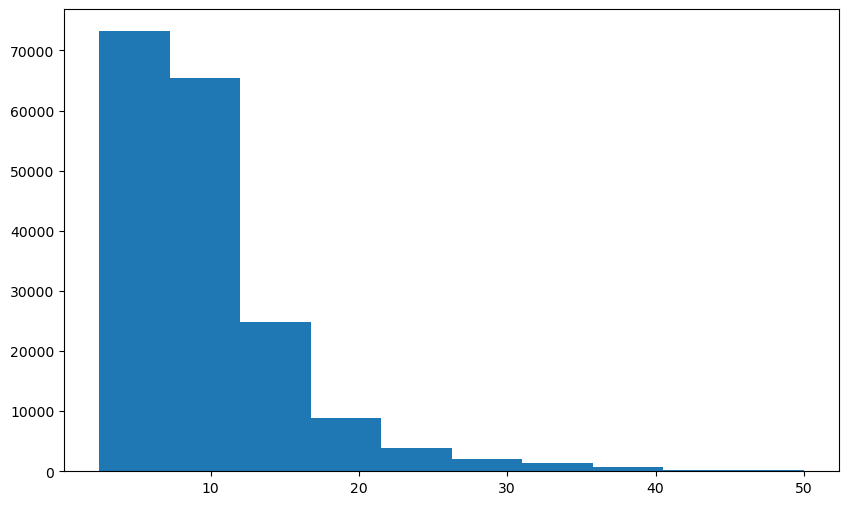

In [22]:
# recheck the distribution plot of the "fare_amount" variable
plt.figure(figsize = (10,6))
plt.hist(df_final['fare_amount'])
plt.show()

In [23]:
# print the shape of the final dataset
df_final.shape

(180579, 7)

**Insights:**
- The final data set contains 185946 observations and 8 features with non missing values.
- Our problem is a regression problem and the target variable is the fare amount. The minimum dollar amount of a taxi ride is 2.5 dollars and the maximum amount is 50 dollars.
- There are four features that give us information about longitudes and latitudes for each pickup and dropoff ride. We can use this information to calculate the distance between a pickup point and a dropoff point.
- The datetime column is another interesting feature on which we can do some feature engineering to extract some useful information, for example the hour of the ride and the day of the week.

**Feature engineering**

In [24]:
# feature engineering
# the dataset has four columns that give information about longitudes and latitudes
# with this information we can calculate the haversine distance
# the below code is function that calculates the haversine distance
def haversine_distance(df, lat1, lat2, lon1, lon2):
  """This function calculates the haversine distance between 2 points of a sphere"""
  r = 6371 # earth radius in kilometers
  # convert latitudes and longitudes to radians
  phi1 = np.radians(df[lat1])
  phi2 = np.radians(df[lat2])
  lambda1 = np.radians(df[lon1])
  lambda2 = np.radians(df[lon2])
  # haversine formula
  a = np.sin((phi2 - phi1) / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin((lambda2 - lambda1) / 2)**2
  c = 2 * np.arcsin(np.sqrt(a))
  d = c * r # distance in kilometers
  return d

In [25]:
# create a new column that contains the haversine distance using the function we just coded
df_final['dist_km'] = haversine_distance(df_final, 'pickup_latitude', 'dropoff_latitude', 'pickup_longitude', 'dropoff_longitude')
df_final.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,8.450134
1,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,1.389525
2,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,2.799270
3,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,1.999157
4,12.1,2011-01-06 09:50:45 UTC,-74.000964,40.731630,-73.972892,40.758233,1,3.787239


In [26]:
# we can also extract some useful features from the "pickup_datetime" column
# this column is stored as a string column, we need to convert it to datetime type column
df_final['pickup_datetime'] = pd.to_datetime(df_final['pickup_datetime'])
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180579 entries, 0 to 180578
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   fare_amount        180579 non-null  float64            
 1   pickup_datetime    180579 non-null  datetime64[ns, UTC]
 2   pickup_longitude   180579 non-null  float64            
 3   pickup_latitude    180579 non-null  float64            
 4   dropoff_longitude  180579 non-null  float64            
 5   dropoff_latitude   180579 non-null  float64            
 6   passenger_count    180579 non-null  int64              
 7   dist_km            180579 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(6), int64(1)
memory usage: 11.0 MB


In [27]:
# print the first rows of the dataframe
df_final.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,8.450134
1,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389525
2,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,2.799270
3,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,1.999157
4,12.1,2011-01-06 09:50:45+00:00,-74.000964,40.731630,-73.972892,40.758233,1,3.787239


In [28]:
# we now see that the "pickup_datetime" column is converted to a datetime type feature
# now we can perform some more feature engineering on this column
# let's visualize the datetime of the first row and see what we can extract
mytime = df_final['pickup_datetime'][0]
mytime

Timestamp('2010-01-05 16:52:16+0000', tz='UTC')

In [29]:
# one thing important to notice is the time zone which is UTC
# the time zone of New York city is Eastern Daylight Time (EDT) which is 4 hours behind UTC
# that's an important information if we want to create a feature with the AM and PM time format
# create a new column that contains the eastern daylight time
df_final['EDT'] = df_final['pickup_datetime'] - pd.Timedelta(hours = 4)

# create a new column that indicates the hour
df_final['Hour'] = df_final['EDT'].dt.hour

# create a new column that indicates in which half of the day the time belongs to, AM or PM
df_final['AMorPM'] = np.where(df_final['Hour'] < 12, 'AM', 'PM')

# create a new column that contains the weekday
df_final['Weekday'] = df_final['pickup_datetime'].dt.strftime('%a')
df_final.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDT,Hour,AMorPM,Weekday
0,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,8.450134,2010-01-05 12:52:16+00:00,12,PM,Tue
1,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389525,2011-08-17 20:35:00+00:00,20,PM,Thu
2,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,2.799270,2012-04-21 00:30:42+00:00,0,AM,Sat
3,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,1.999157,2010-03-09 03:51:00+00:00,3,AM,Tue
4,12.1,2011-01-06 09:50:45+00:00,-74.000964,40.731630,-73.972892,40.758233,1,3.787239,2011-01-06 05:50:45+00:00,5,AM,Thu


In [30]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180579 entries, 0 to 180578
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   fare_amount        180579 non-null  float64            
 1   pickup_datetime    180579 non-null  datetime64[ns, UTC]
 2   pickup_longitude   180579 non-null  float64            
 3   pickup_latitude    180579 non-null  float64            
 4   dropoff_longitude  180579 non-null  float64            
 5   dropoff_latitude   180579 non-null  float64            
 6   passenger_count    180579 non-null  int64              
 7   dist_km            180579 non-null  float64            
 8   EDT                180579 non-null  datetime64[ns, UTC]
 9   Hour               180579 non-null  int64              
 10  AMorPM             180579 non-null  object             
 11  Weekday            180579 non-null  object             
dtypes: datetime64[ns, UTC](2), flo

**Categorical and continuous features**

In [31]:
# our dataframe now has a mix of both categorical and continuous variables
# let's separate the categorical and continuous variables, store the target in a separate variable as well
cat_cols = ['Hour', 'AMorPM', 'Weekday']
cont_cols = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'dist_km']
y_cont = ['fare_amount']

# the df.info() shows that the categorical features are stored as stings or integer data types
# what we need to do next is to convert those features into categorical data types
for cat in cat_cols:
  df_final[cat] = df_final[cat].astype('category')

# check the data types
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180579 entries, 0 to 180578
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   fare_amount        180579 non-null  float64            
 1   pickup_datetime    180579 non-null  datetime64[ns, UTC]
 2   pickup_longitude   180579 non-null  float64            
 3   pickup_latitude    180579 non-null  float64            
 4   dropoff_longitude  180579 non-null  float64            
 5   dropoff_latitude   180579 non-null  float64            
 6   passenger_count    180579 non-null  int64              
 7   dist_km            180579 non-null  float64            
 8   EDT                180579 non-null  datetime64[ns, UTC]
 9   Hour               180579 non-null  category           
 10  AMorPM             180579 non-null  category           
 11  Weekday            180579 non-null  category           
dtypes: category(3), datetime64[ns,

In [32]:
# the variables are now converted into category data type
# let's print the number of categories that each variable has
print('The number of categories in the "Hour" column is:', df_final['Hour'].nunique())
print('The number of categories in the "AMorPM" column is:', df_final['AMorPM'].nunique())
print('The number of categories in the "Weekday" column is:', df_final['Weekday'].nunique())

The number of categories in the "Hour" column is: 24
The number of categories in the "AMorPM" column is: 2
The number of categories in the "Weekday" column is: 7


In [33]:
# so the number of categories in the "Hour" column is 24 which corresponds to 24 hours
# the number of categories in the "AMorPM" column is 2: AM and PM
# the number of categories in the "Weekday" column is 7 which corresponds to the 7 days of the week
# for each column, every category is associated with a code
# let's print the categories and the associated codes for each column
print('Hour categories\n:', df_final['Hour'].cat.categories)
print('Hour codes\n:', df_final['Hour'].cat.codes)
print('\n\nAMorPM categories\n:', df_final['AMorPM'].cat.categories)
print('AMorPM codes\n:', df_final['Hour'].cat.codes)
print('\n\nWeekday categories\n:', df_final['Weekday'].cat.categories)
print('Weekday codes\n:', df_final['Weekday'].cat.codes)

Hour categories
: Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23],
           dtype='int64')
Hour codes
: 0         12
1         20
2          0
3          3
4          5
          ..
180574    19
180575     7
180576     9
180577    14
180578    15
Length: 180579, dtype: int8


AMorPM categories
: Index(['AM', 'PM'], dtype='object')
AMorPM codes
: 0         12
1         20
2          0
3          3
4          5
          ..
180574    19
180575     7
180576     9
180577    14
180578    15
Length: 180579, dtype: int8


Weekday categories
: Index(['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed'], dtype='object')
Weekday codes
: 0         5
1         4
2         2
3         5
4         4
         ..
180574    4
180575    4
180576    4
180577    2
180578    0
Length: 180579, dtype: int8


In [34]:
# store the these associated codes in separate variables
hour = df_final['Hour'].cat.codes.values # numpy array
amorpm = df_final['AMorPM'].cat.codes.values # numpy array
weekday = df_final['Weekday'].cat.codes.values # numpy array

# stack these variables by column
cats = np.stack([hour, amorpm, weekday], axis = 1)
# note: we can do the same thing with a list comprehension
cats = np.stack([df_final[c].cat.codes.values for c in cat_cols], axis = 1)
cats

array([[12,  1,  5],
       [20,  1,  4],
       [ 0,  0,  2],
       ...,
       [ 9,  0,  4],
       [14,  1,  2],
       [15,  1,  0]], dtype=int8)

In [35]:
# apply the same process to stack the continous variables
conts = np.stack([df_final[c] for c in cont_cols], axis = 1)
conts

array([[-74.016048  ,  40.711303  , -73.979268  ,  40.782004  ,
          1.        ,   8.4501336 ],
       [-73.982738  ,  40.76127   , -73.991242  ,  40.750562  ,
          2.        ,   1.38952523],
       [-73.98713   ,  40.733143  , -73.991567  ,  40.758092  ,
          1.        ,   2.79927024],
       ...,
       [-73.95401   ,  40.78454   , -73.99029   ,  40.754177  ,
          5.        ,   4.5533844 ],
       [-73.990152  ,  40.740837  , -73.995193  ,  40.760206  ,
          4.        ,   2.19519687],
       [-73.972328  ,  40.745277  , -73.987682  ,  40.739162  ,
          1.        ,   1.46135785]])

In [36]:
# convert the two matrices to tensors
cats = torch.tensor(data = cats, dtype = torch.int64)
conts = torch.tensor(data = conts, dtype = torch.float)

# print the stacked categories
cats

tensor([[12,  1,  5],
        [20,  1,  4],
        [ 0,  0,  2],
        ...,
        [ 9,  0,  4],
        [14,  1,  2],
        [15,  1,  0]])

In [37]:
# print the stacked continuous variables
conts

tensor([[-74.0160,  40.7113, -73.9793,  40.7820,   1.0000,   8.4501],
        [-73.9827,  40.7613, -73.9912,  40.7506,   2.0000,   1.3895],
        [-73.9871,  40.7331, -73.9916,  40.7581,   1.0000,   2.7993],
        ...,
        [-73.9540,  40.7845, -73.9903,  40.7542,   5.0000,   4.5534],
        [-73.9902,  40.7408, -73.9952,  40.7602,   4.0000,   2.1952],
        [-73.9723,  40.7453, -73.9877,  40.7392,   1.0000,   1.4614]])

In [38]:
# finally convert the target variable to a tensor
y = torch.tensor(data = df_final[y_cont].values, dtype = torch.float).reshape(-1,1)
y

tensor([[16.9000],
        [ 5.7000],
        [ 7.7000],
        ...,
        [23.0000],
        [ 8.9000],
        [12.0000]])

In [39]:
y.shape

torch.Size([180579, 1])

In [40]:
# use embedding for categorical variables
# print the size of each category
cat_size = [df_final[c].nunique() for c in df_final[cat_cols]]
cat_size

[24, 2, 7]

In [41]:
# determine the size of our embedding
# we take half of the unique values of the categories and add one
embedding_size = [(size, min(50, (size + 1) // 2)) for size in cat_size]
embedding_size

[(24, 12), (2, 1), (7, 4)]

**Build the model**

In [42]:
# reorganize the embedding sizes in a pytorch module list
emb_mod = nn.ModuleList([nn.Embedding(num_embeddings = ne, embedding_dim = ed) for ne, ed in embedding_size])
emb_mod

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [43]:
emb_mod[0].embedding_dim

12

In [44]:
# store the total sum of the embedding dimensions
emb_dim = sum([embedding.embedding_dim for embedding in emb_mod])
emb_dim

17

In [45]:
# test the embedding modules on a sample of the tensor "cats"
# let's say we take the first 4 rows of the tensor
catz = cats[:4]
catz

tensor([[12,  1,  5],
        [20,  1,  4],
        [ 0,  0,  2],
        [ 3,  0,  5]])

In [46]:
# forward mathod (cats)
emb_list = []
for i, e in enumerate(emb_mod):
  emb_list.append(e(catz[:,i]))

emb_list

[tensor([[ 0.7599,  0.8017,  2.3234, -0.0373,  0.9909, -0.4143,  0.1638,  0.6210,
          -1.5808, -1.0419, -1.6738,  1.7289],
         [-1.4333,  4.0723,  1.2602, -0.3211,  1.3199,  0.5101,  0.3897, -0.2692,
          -1.2624, -0.5096, -0.5206, -1.3142],
         [ 0.8143, -0.5166,  0.0832,  0.2833,  0.7170, -0.8344, -1.6175,  0.3932,
           0.9349,  0.6513,  0.6819, -0.1124],
         [-0.9168,  0.7006,  1.4448,  1.4658,  1.3445,  0.2518, -0.9379,  2.2053,
          -0.9105,  0.5141, -0.5943, -0.8491]], grad_fn=<EmbeddingBackward0>),
 tensor([[0.2584],
         [0.2584],
         [0.7736],
         [0.7736]], grad_fn=<EmbeddingBackward0>),
 tensor([[ 1.2837,  0.1740,  1.2318, -0.9521],
         [ 0.7094,  0.5756, -0.4267, -1.6629],
         [ 0.0590, -1.6531, -0.4126,  0.6534],
         [ 1.2837,  0.1740,  1.2318, -0.9521]], grad_fn=<EmbeddingBackward0>)]

In [47]:
# concatenate the tensors
emb_concatenated = torch.cat(emb_list, axis = 1)
emb_concatenated

tensor([[ 0.7599,  0.8017,  2.3234, -0.0373,  0.9909, -0.4143,  0.1638,  0.6210,
         -1.5808, -1.0419, -1.6738,  1.7289,  0.2584,  1.2837,  0.1740,  1.2318,
         -0.9521],
        [-1.4333,  4.0723,  1.2602, -0.3211,  1.3199,  0.5101,  0.3897, -0.2692,
         -1.2624, -0.5096, -0.5206, -1.3142,  0.2584,  0.7094,  0.5756, -0.4267,
         -1.6629],
        [ 0.8143, -0.5166,  0.0832,  0.2833,  0.7170, -0.8344, -1.6175,  0.3932,
          0.9349,  0.6513,  0.6819, -0.1124,  0.7736,  0.0590, -1.6531, -0.4126,
          0.6534],
        [-0.9168,  0.7006,  1.4448,  1.4658,  1.3445,  0.2518, -0.9379,  2.2053,
         -0.9105,  0.5141, -0.5943, -0.8491,  0.7736,  1.2837,  0.1740,  1.2318,
         -0.9521]], grad_fn=<CatBackward0>)

In [48]:
# pass the embedding layer through a dropout layer
emb_drop = nn.Dropout(0.4)
emb_concatenated = emb_drop(emb_concatenated)
emb_concatenated

tensor([[ 0.0000,  0.0000,  0.0000, -0.0622,  1.6514, -0.0000,  0.2730,  1.0350,
         -0.0000, -0.0000, -0.0000,  2.8814,  0.0000,  2.1394,  0.2901,  2.0531,
         -0.0000],
        [-0.0000,  6.7872,  2.1003, -0.5351,  2.1998,  0.8502,  0.6494, -0.4487,
         -2.1040, -0.8493, -0.8676, -0.0000,  0.4306,  0.0000,  0.9594, -0.0000,
         -2.7715],
        [ 1.3571, -0.0000,  0.1387,  0.4722,  1.1950, -0.0000, -0.0000,  0.6553,
          1.5581,  0.0000,  0.0000, -0.1873,  1.2893,  0.0000, -0.0000, -0.6877,
          0.0000],
        [-0.0000,  0.0000,  2.4080,  2.4430,  2.2408,  0.4197, -1.5632,  0.0000,
         -0.0000,  0.8568, -0.9904, -1.4151,  1.2893,  0.0000,  0.2901,  0.0000,
         -1.5868]], grad_fn=<MulBackward0>)

In [49]:
# the last 4 steps above are techniques intended for test purposes only
# these techniques will be used when we'll define the neural network
# define the neural network model
class Model(nn.Module):
  def __init__(self, emb_size, n_conts, layers, out_sz, p = 0.5):
    # layers = [200, 100, 50]
    super().__init__()

    self.emb_mod = nn.ModuleList([nn.Embedding(num_embeddings = ni, embedding_dim = ed) for ni, ed in emb_size])
    self.emb_drop = nn.Dropout(p)
    self.bn_cont = nn.BatchNorm1d(n_conts)

    n_emb_dim = sum([embedding.embedding_dim for embedding in emb_mod])
    nf = n_emb_dim + n_conts
    layerslist = []
    for i in layers:
      layerslist.append(nn.Linear(nf, i))
      layerslist.append(nn.ReLU(inplace = True))
      layerslist.append(nn.BatchNorm1d(i))
      layerslist.append(nn.Dropout(p))
      nf = i
    layerslist.append(nn.Linear(layers[-1], out_sz))
    self.layers = nn.Sequential(*layerslist)

  def forward(self, x_cat, x_cont):
    emb_list = []
    for i, e in enumerate(self.emb_mod):
      emb_list.append(e(x_cat[:,i]))
    x = torch.cat(emb_list, axis = 1)
    x = self.emb_drop(x)
    x_cont = self.bn_cont(x_cont)
    x = torch.cat([x, x_cont], axis = 1)
    x = self.layers(x)
    return x

**Train and evaluate the model**

In [50]:
# split the data into train, validation and test sets
batch_size = df_final.shape[0]
test_size = int(batch_size * 0.2)
cat_train = cats[:batch_size-test_size]
con_train = conts[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_test = conts[batch_size-test_size:batch_size]
val_size = int(cat_train.shape[0] * 0.2)
cat_val = cat_train[cat_train.shape[0]-val_size:cat_train.shape[0]]
con_val = con_train[con_train.shape[0]-val_size:con_train.shape[0]]
cat_train = cat_train[:cat_train.shape[0]-val_size]
con_train = con_train[:con_train.shape[0]-val_size]
y_train = y[:batch_size-test_size]
y_val = y_train[y_train.shape[0]-val_size:y_train.shape[0]]
y_train = y_train[:y_train.shape[0]-val_size]
y_test = y[batch_size-test_size:batch_size]

In [51]:
# print the shape of the splitted sets
print('cat_train.shape:', cat_train.shape)
print('con_train.shape:', con_train.shape)
print('cat_val.shape:', cat_val.shape)
print('con_val.shape:', con_val.shape)
print('cat_test.shape:', cat_test.shape)
print('con_test.shape:', con_test.shape)
print('y_train.shape:', y_train.shape)
print('y_val.shape:', y_val.shape)
print('y_test.shape:', y_test.shape)

cat_train.shape: torch.Size([115572, 3])
con_train.shape: torch.Size([115572, 6])
cat_val.shape: torch.Size([28892, 3])
con_val.shape: torch.Size([28892, 6])
cat_test.shape: torch.Size([36115, 3])
con_test.shape: torch.Size([36115, 6])
y_train.shape: torch.Size([115572, 1])
y_val.shape: torch.Size([28892, 1])
y_test.shape: torch.Size([36115, 1])


In [52]:
# create an instance of the model
model = Model(embedding_size, conts.shape[1], [100, 50], 1, p = 0.4)

# this model has 1 input layer, 2 hidden layers and 1 output layer
# the dropout value is 0.4
model

Model(
  (emb_mod): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=100, out_features=50, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [53]:
# train the model
criterion = nn.MSELoss() # set the loss function
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
# define an early stopping function
def early_stopping(losses, patience = 3):
  """This early stopping function stops training if the validation
  loss does not improve after 3 consecutive epochs"""
  if len(losses) > patience:
    if losses[-1] >= max(losses[-1-patience:-1]):
      return True
  return False

epochs = 500
train_loss = []
val_loss = []

start_time = time.time()

for i in range(epochs):
  i += 1
  y_pred_train = model(cat_train, con_train)
  loss_a = torch.sqrt(criterion(y_pred_train, y_train))
  train_loss.append(loss_a.detach().numpy())
  optimizer.zero_grad()
  loss_a.backward()
  optimizer.step()

  with torch.no_grad():
    y_pred_val = model(cat_val, con_val)
    loss_b = torch.sqrt(criterion(y_pred_val, y_val))
    val_loss.append(loss_b.detach().numpy())

  early_stop = early_stopping(val_loss, patience = 3)

  if early_stop:
      print('\nThe training is terminated to avoid overfitting.')
      break

  print(f'Epoch: {i} Train_loss: {loss_a} Val_loss: {loss_b}')

end_time = time.time()

# calculate the execution time
print(f'\nThe time of execution is: {(end_time - start_time) / 60} minutes')

Epoch: 1 Train_loss: 11.244749069213867 Val_loss: 11.222382545471191
Epoch: 2 Train_loss: 11.212297439575195 Val_loss: 11.182516098022461
Epoch: 3 Train_loss: 11.177755355834961 Val_loss: 11.148321151733398
Epoch: 4 Train_loss: 11.142568588256836 Val_loss: 11.108942985534668
Epoch: 5 Train_loss: 11.10972785949707 Val_loss: 11.068931579589844
Epoch: 6 Train_loss: 11.068083763122559 Val_loss: 11.035297393798828
Epoch: 7 Train_loss: 11.0418701171875 Val_loss: 11.006389617919922
Epoch: 8 Train_loss: 11.019100189208984 Val_loss: 10.95338249206543
Epoch: 9 Train_loss: 10.980683326721191 Val_loss: 10.92278003692627
Epoch: 10 Train_loss: 10.943100929260254 Val_loss: 10.886717796325684
Epoch: 11 Train_loss: 10.913955688476562 Val_loss: 10.8521089553833
Epoch: 12 Train_loss: 10.880087852478027 Val_loss: 10.808122634887695
Epoch: 13 Train_loss: 10.855396270751953 Val_loss: 10.773441314697266
Epoch: 14 Train_loss: 10.815752029418945 Val_loss: 10.73764705657959
Epoch: 15 Train_loss: 10.781806945800

Epoch: 121 Train_loss: 8.933514595031738 Val_loss: 8.928093910217285
Epoch: 122 Train_loss: 8.917370796203613 Val_loss: 8.923195838928223
Epoch: 123 Train_loss: 8.896604537963867 Val_loss: 8.891216278076172
Epoch: 124 Train_loss: 8.876983642578125 Val_loss: 8.875728607177734
Epoch: 125 Train_loss: 8.8538236618042 Val_loss: 8.843806266784668
Epoch: 126 Train_loss: 8.842313766479492 Val_loss: 8.839861869812012
Epoch: 127 Train_loss: 8.825594902038574 Val_loss: 8.820266723632812
Epoch: 128 Train_loss: 8.798007011413574 Val_loss: 8.784574508666992
Epoch: 129 Train_loss: 8.765466690063477 Val_loss: 8.766501426696777
Epoch: 130 Train_loss: 8.770918846130371 Val_loss: 8.756921768188477
Epoch: 131 Train_loss: 8.737829208374023 Val_loss: 8.72642707824707
Epoch: 132 Train_loss: 8.705621719360352 Val_loss: 8.69812297821045
Epoch: 133 Train_loss: 8.703782081604004 Val_loss: 8.686505317687988
Epoch: 134 Train_loss: 8.672745704650879 Val_loss: 8.659746170043945
Epoch: 135 Train_loss: 8.6339044570922

Epoch: 241 Train_loss: 5.244253158569336 Val_loss: 5.207347393035889
Epoch: 242 Train_loss: 5.2261962890625 Val_loss: 5.183277130126953
Epoch: 243 Train_loss: 5.203444957733154 Val_loss: 5.157878875732422
Epoch: 244 Train_loss: 5.145395755767822 Val_loss: 5.133691787719727
Epoch: 245 Train_loss: 5.107692718505859 Val_loss: 5.112475872039795
Epoch: 246 Train_loss: 5.078869342803955 Val_loss: 5.063713073730469
Epoch: 247 Train_loss: 5.043224334716797 Val_loss: 5.024939060211182
Epoch: 248 Train_loss: 5.013659954071045 Val_loss: 5.003342151641846
Epoch: 249 Train_loss: 4.997070789337158 Val_loss: 4.9601006507873535
Epoch: 250 Train_loss: 4.945926189422607 Val_loss: 4.910720348358154
Epoch: 251 Train_loss: 4.937302112579346 Val_loss: 4.903592109680176
Epoch: 252 Train_loss: 4.895185947418213 Val_loss: 4.861097812652588
Epoch: 253 Train_loss: 4.874495506286621 Val_loss: 4.843328475952148
Epoch: 254 Train_loss: 4.829924583435059 Val_loss: 4.810204982757568
Epoch: 255 Train_loss: 4.8532285690

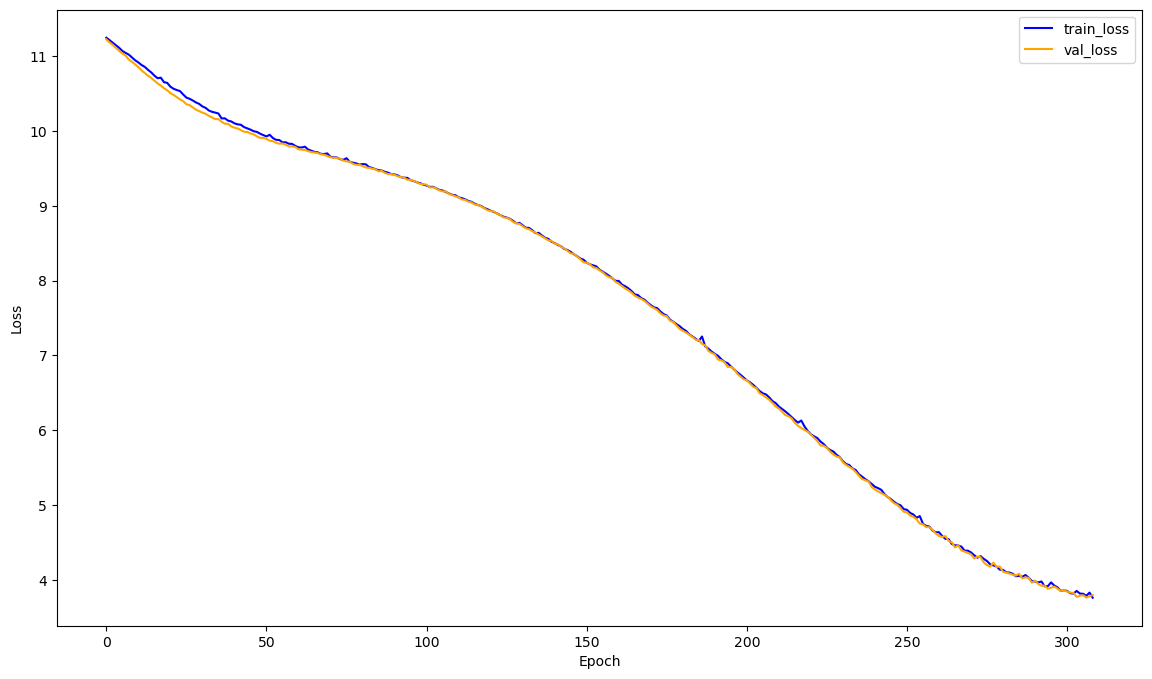

In [54]:
# plot the loss
plt.figure(figsize = (14,8))
plt.plot(range(i), train_loss, label = 'train_loss', color = 'blue')
plt.plot(range(i), val_loss, label = 'val_loss', color = 'orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [55]:
# test the model on the test data
with torch.no_grad():
  y_pred_test = model(cat_test, con_test)
  loss = torch.sqrt(criterion(y_pred_test, y_test))
loss.item()

3.79360294342041

**Conclusion:**  
The use of a neural network with two hidden layers proved to be efficient enough to get an RMSE score lower than 5. The embedding technique helped the model learn more about the relationships between the inputs and reduce the dimensionality of the data as well. I added a dropout layer with a value of 0.4 which helped the model to avoid overfitting after 308 epochs. I spent considerable time on optimizing the hyperparameters and trying several machine learning techniques before sticking to the final result which is an RSME score of 3.79. Of course, this result can still be improved.  